In [3]:
import sqlutilpy as sqlutil 
import numpy as np
from idlplotInd import tvhist2d, oplot
import matplotlib.pyplot as plt
import dustmaps.sfd as SFD

In [4]:
%matplotlib inline

In [5]:
wsdb_host = open('/home/skoposov/WSDB_host').readline().rstrip()
rad = 15
area = np.pi*rad**2
X = sqlutil.get(
        ''' select ra,dec,flux_g,flux_r,flux_z,flux_w1,flux_w2,pmra,pmdec,
        pmra_ivar,pmdec_ivar,parallax,parallax_ivar from decals_dr7.main 
        where q3c_radial_query(ra,dec,180,20,%d) and type='PSF' and brick_primary;'''%(rad),
        asDict=True,host=wsdb_host)


In [20]:
g,r,z,w1,w2=[22.5-2.5*np.log10(X['flux_'+_]) for _ in ['g','r','z','w1','w2']]
ebv = SFD.SFDQuery().query_equ(X['ra'],X['dec'])
eg,er,ez,ew1,ew2=[ebv*_ for _ in [3.237,2.176,1.217,.19,.15]]
plx,eplx=X['parallax'],1./X['parallax_ivar']**.5
pmra,pmdec=X['pmra'],X['pmdec']
epmra,epmdec = 1./X['pmra_ivar']**.5,1./X['pmdec_ivar']**.5


/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.
/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [47]:
# Selection by parallax that is robust to systematics and complete

plxsel = plx<np.maximum(3*eplx,.1)

bhbdist = 10**((g-eg-0.5)/5.-2) # approximate distance to a star assuming it is a bhb

maxvel = 1000 
bhbpmsel = np.sqrt(pmra**2+pmdec**2)< (maxvel / bhbdist / 4.74 + 2 * np.sqrt(epmra**2+epmdec**2)) 
# stars having a velocity constitent within 3sigma of 1000 km/s  
wisesel = (~np.isfinite(w1))|((r-w1-er+ew1)<-1) 

/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in subtract
  
/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


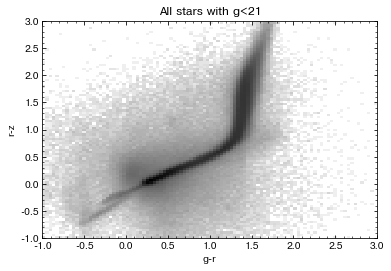

In [22]:
# All stars with g<21
tvhist2d(g-r-eg+er,r-z-er+ez,-1,3,-1,3, ind=(r<21), zlog=True,xtitle='g-r',ytitle='r-z',title='All stars with g<21')

/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in subtract
  
/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


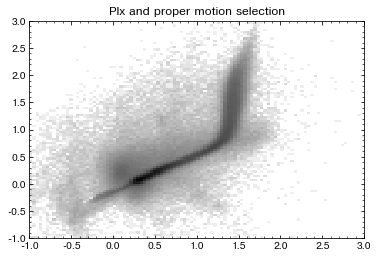

In [23]:

tvhist2d(g-r,r-z,-1,3,-1,3, ind=(r<21)&bhbpmsel&plxsel, zlog=True, title='Plx and proper motion selection')

/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in subtract
  """Entry point for launching an IPython kernel.
/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


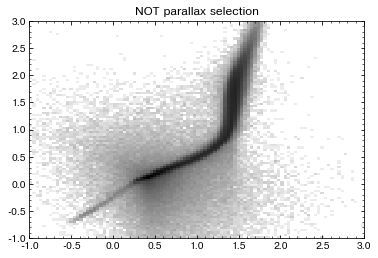

In [24]:
tvhist2d(g-r,r-z,-1,3,-1,3, ind=(r<21)&(~plxsel), zlog=True, title='NOT parallax selection')

/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in subtract
  """Entry point for launching an IPython kernel.
/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


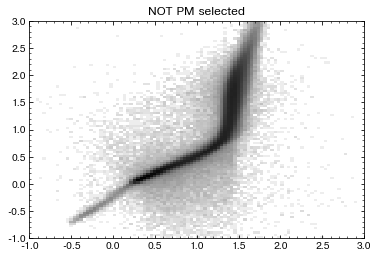

In [25]:
tvhist2d(g-r,r-z,-1,3,-1,3, ind=(r<21)&(~bhbpmsel), zlog=True, title='NOT PM selected')

/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in subtract
  """Entry point for launching an IPython kernel.
/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


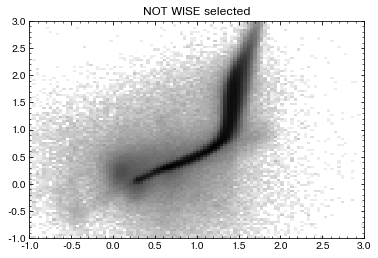

In [49]:
tvhist2d(g-r,r-z,-1,3,-1,3, ind=(r<21)&(~wisesel), zlog=True, title='NOT WISE selected')

/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in subtract
  """Entry point for launching an IPython kernel.
/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


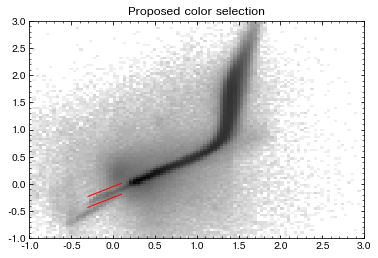

In [50]:
tvhist2d(g-r-eg+er,r-z-er+ez,-1,3,-1,3, ind=(r<21), zlog=True, title='Proposed color selection')
xgrid=np.linspace(-0.3,0.1)
oplot(xgrid,.6*xgrid-.25,color='red')
oplot(xgrid,.6*xgrid-.05,color='red')


In [54]:
betw= lambda x,x1,x2:(x>=x1)&(x<x2)
bhbcolsel = betw(g-r-eg+er,-0.3,0.1) & betw(r-z-er+ez-0.6*(g-r-eg+er),-0.25,-0.05)


/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in subtract
  
/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater_equal
  """Entry point for launching an IPython kernel.
/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


In [52]:
mainsel = plxsel & bhbcolsel & bhbpmsel & wisesel

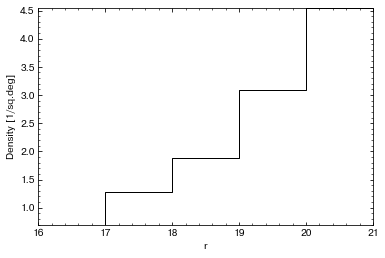

In [55]:
plothist(r, ind=mainsel,min=16,max=21,bin=1,weights=1./area,ytitle='Density [1/sq.deg]',xtitle='r'
        )

In [56]:
xra,xdec,xg,xr,xz,xw1,xw2=sqlutil.get('''
with x as (select ra,dec from sdssdr9.specphotoall  as sp, sdssdr9.sppparams as spp 
where sp.specobjid=spp.specobjid and loggadop between 2 and 3.5 and elodiervfinal between -500 and 500 and 
sp.scienceprimary=1 
and teffadop>7200
order by q3c_ang2ipix(ra,dec)) select x.ra,x.dec,flux_g,flux_r,flux_z,flux_w1,flux_w2 from x, decals_dr7.main as d where 
q3c_join(x.ra,x.dec,d.ra,d.dec,1./3600);
''',host=wsdb_host)
xebv = SFD.SFDQuery().query_equ(xra,xdec)
xg,xr,xz=[22.5-2.5*np.log10(_) for _ in [xg,xr,xz]]
xeg,xer,xez,xew1,xew2=[xebv*_ for _ in [3.237,2.176,1.217,.19,.15]]


/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.


/home/skoposov/pyenv36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in subtract
  """Entry point for launching an IPython kernel.


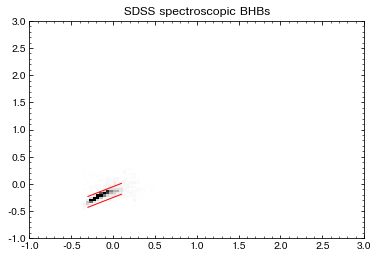

In [57]:
tvhist2d(xg-xr-xeg+xer,xr-xz-xer+xez,-1,3,-1,3,vmaxfrac=.9995, title='SDSS spectroscopic BHBs')
oplot(xgrid,.6*xgrid-.25,color='red')
oplot(xgrid,.6*xgrid-.05,color='red')
